## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from random import sample
from itertools import chain
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
110246,00030020_000.png,No Finding,0,30020,68,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030020_000.png
81100,00019919_020.png,Emphysema|Pleural_Thickening|Pneumothorax,20,19919,52,M,PA,2610,2465,0.143000,0.143000,NaN,/data/images_009/images/00019919_020.png
105778,00028478_002.png,No Finding,2,28478,52,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_012/images/00028478_002.png


In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].str.split('|').tolist())))
for i in all_labels:
    all_xray_df[i] = all_xray_df['Finding Labels'].map(lambda x : 1.0 if i in x else 0)

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneomonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia']==1.0 else 'N',axis=1)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneomonia_class
81850,00020135_001.png,Atelectasis|Effusion|Infiltration,1,20135,53,M,PA,2824,2561,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,N
28598,00007460_000.png,No Finding,0,7460,45,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
23487,00006220_011.png,Atelectasis|Consolidation,11,6220,8,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


## Creating training and testing data:

In [5]:
def create_splits(**vargs):
    
    ## Split the original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced we want each of those sets to be
    ## for the presence of pneumonia
    
    df = vargs['df']
    train_df, valid_df = skl.train_test_split(df,test_size=0.2,stratify=df['pneomonia_class'])
    train_df_ratio = len(train_df[train_df['pneomonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneomonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Valid set pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    # make training set contain same number of positive and negative cases
    train_pos_inds = train_df[train_df['pneomonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneomonia_class'] == 'N'].index.tolist()
    
    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]
    
    train_df_ratio = len(train_df[train_df['pneomonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # make validation set contain 80% positive and 20% negative cases
    valid_pos_inds = valid_df[valid_df['pneomonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneomonia_class'] == 'N'].index.tolist()
    
    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]
    
    valid_df_ratio = len(valid_df[valid_df['pneomonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df

In [6]:
df_train,df_valid = create_splits(df=all_xray_df)

Initial split. Train set pneumonia: 1.28%. Valid set pneumonia: 1.28%
Train set corrected (50/50), pneumonia: 50.00%
Valid set corrected (20/80), pneumonia: 20.00%


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
img_size = (224,224)
def my_image_augmentation(**vargs):
    
    
    rotation = vargs['rotation'] if 'rotatation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else 0.1
    zoom = vargs['zoom'] if 'zoom' in vargs else 0.1
    
    gen = ImageDataGenerator(rescale = 1. / 255.0,
                            horizontal_flip=True,
                            vertical_flip=False,
                            rotation_range=rotation,
                            shear_range=shear,
                            zoom_range=zoom,
                            height_shift_range=0.1,
                            width_shift_range=0.1)
    
    
    return gen


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    df = vargs['df']
    aug = my_image_augmentation(**vargs)
    train_gen = aug.flow_from_dataframe(dataframe=df,
                                       directory=None,
                                       x_col = 'path',
                                       y_col = 'pneomonia_class',
                                       target_size = img_size,
                                       batch_size=12,
                                       class_mode='binary')
    return train_gen


def make_val_gen(**vargs):
    df = vargs['df']
    gen = ImageDataGenerator(rescale = 1. / 255.0,
                            horizontal_flip=True,
                            vertical_flip=False)
    val_gen = gen.flow_from_dataframe(dataframe=df,
                                     directory=None,
                                     x_col='path',
                                     y_col='pneomonia_class',
                                     target_size=img_size,
                                     batch_size=1024,
                                     class_mode='binary')
    return val_gen

In [8]:
train_gen = make_train_gen(df=df_train)
val_gen = make_val_gen(df=df_valid)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

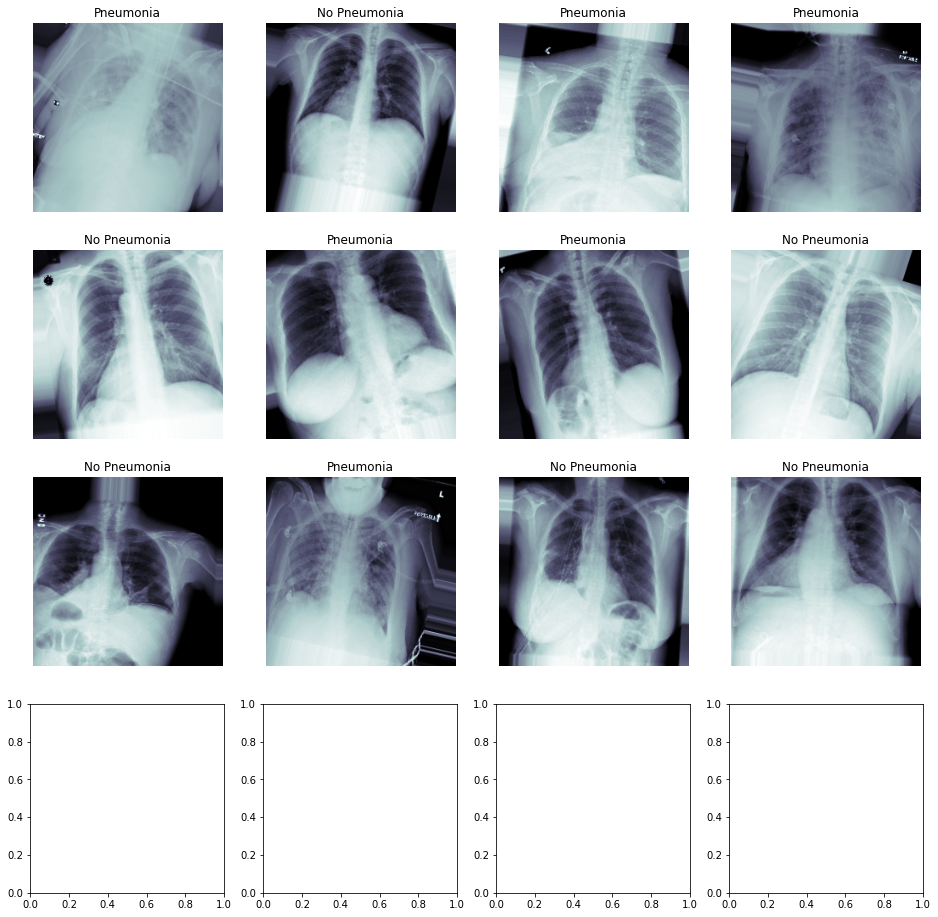

In [10]:
## May want to look at some examples of our augmented training data. 

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
plt.show()

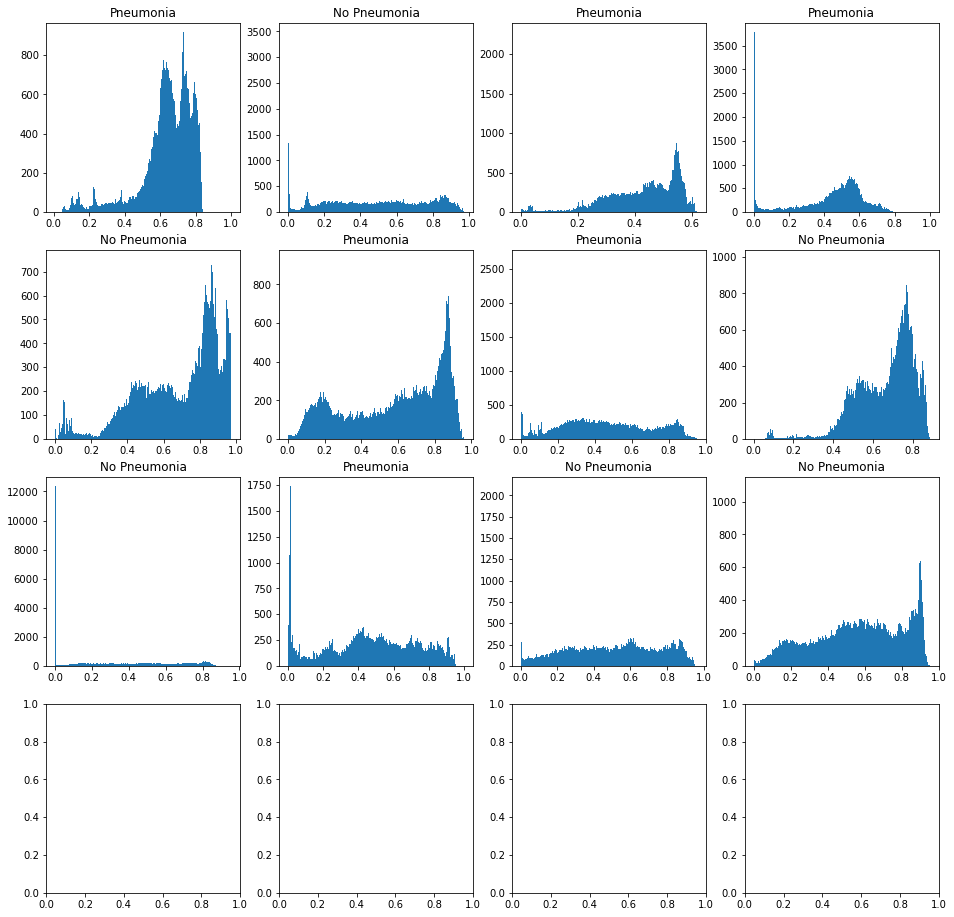

In [11]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (c_x > 0.1) & (c_x < 0.9)
#     d = c_x[mask].flatten().tolist()
    c_ax.hist(c_x[:,:,0].flatten(),bins=256)
    if c_y==1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model(**vargs):
    
    model = VGG16(include_top=True,weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input,outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
        
    for layer in vgg_model.layers:
        print(layer.name,layer.trainable)
    
    return vgg_model


In [13]:
def build_my_model(**vargs):
    
    vgg_model = load_pretrained_model()
    
    new_model=Sequential()
    new_model.add(vgg_model)
    
    new_model.add(Flatten())
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.1))
    
    new_model.add(Dense(1,activation='sigmoid'))
    
    return new_model

In [17]:
model = build_my_model()
model.summary()

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
___________________________________

In [19]:
# optimizer = Adam(lr=1e-5)
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

weight_path = "{}_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path,monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True)
early = EarlyStopping(monitor='val_loss',mode='min',patience=10)
callbacks_list = [checkpoint,early]

### Start training! 

In [20]:
history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
191/191 [==============================] - 73s 384ms/step - loss: 0.7452 - binary_accuracy: 0.5341 - val_loss: 0.7264 - val_binary_accuracy: 0.3291

Epoch 00001: val_loss improved from inf to 0.72641, saving model to xray_class_model.best.hdf5
Epoch 2/100
191/191 [==============================] - 70s 365ms/step - loss: 0.6812 - binary_accuracy: 0.5681 - val_loss: 0.6408 - val_binary_accuracy: 0.7510

Epoch 00002: val_loss improved from 0.72641 to 0.64083, saving model to xray_class_model.best.hdf5
Epoch 3/100
191/191 [==============================] - 71s 373ms/step - loss: 0.6684 - binary_accuracy: 0.6009 - val_loss: 0.7130 - val_binary_accuracy: 0.5166

Epoch 00003: val_loss did not improve from 0.64083
Epoch 4/100
191/191 [==============================] - 71s 371ms/step - loss: 0.6533 - binary_accuracy: 0.6245 - val_loss: 0.5990 - val_binary_accuracy: 0.6611

Epoch 00004: val_loss improved from 0.64083 to 0.59902, saving model to xray_class_model.best.hdf5
Epoch 5/100


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
losses = pd.DataFrame(history.history)

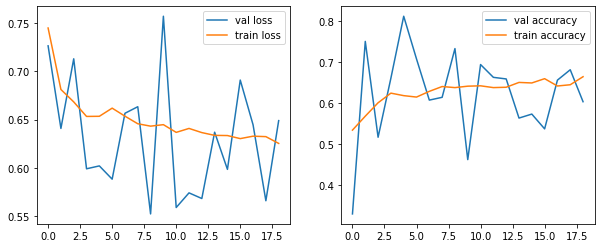

In [40]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

In [41]:
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 13s 12ms/step


In [46]:
def plot_auc(t_y, p_y):
    
    fpr,tpr, thresholds = roc_curve(t_y,p_y,pos_label=1)
    plt.plot(fpr,tpr,color='blue',lw=2)
    plt.plot([0,1],[0,1],color='steelblue',lw=1,linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()
    
def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

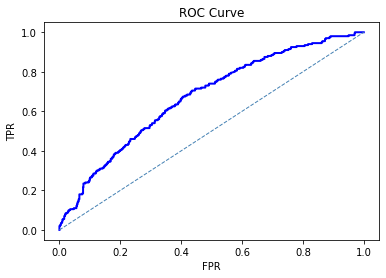

In [47]:
## plot figures
plot_auc(valY,pred_Y)

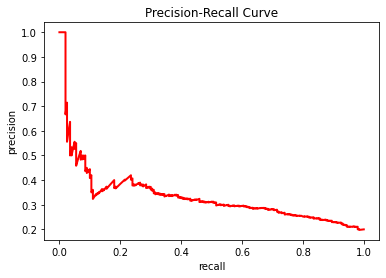

In [48]:
plot_pr(valY,pred_Y)

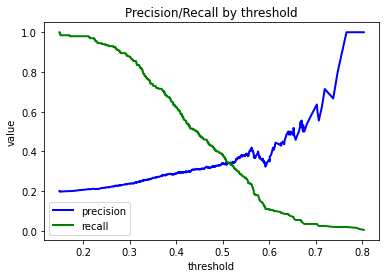

In [51]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision');
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall');
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold');

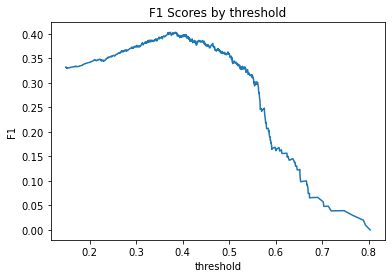

In [61]:
th = 0.5

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

In [63]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.403, threshold: 0.384, precision: 0.287, recall: 0.675


In [64]:
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')
print(f'Recall: {recall[get_index(0.3)] :.3f}, precision: {precision[get_index(0.3)] :.3f}, F1: {f1scores[get_index(0.3)] :.3f}, threshold: {thresholds[get_index(0.3)] :.3f}')
print(f'Recall: {recall[get_index(0.31)] :.3f}, precision: {precision[get_index(0.31)] :.3f}, F1: {f1scores[get_index(0.31)] :.3f}, threshold: {thresholds[get_index(0.31)] :.3f}')
print(f'Recall: {recall[get_index(0.33)] :.3f}, precision: {precision[get_index(0.33)] :.3f}, F1: {f1scores[get_index(0.33)] :.3f}, threshold: {thresholds[get_index(0.33)] :.3f}')
print(f'Recall: {recall[get_index(0.35)] :.3f}, precision: {precision[get_index(0.35)] :.3f}, F1: {f1scores[get_index(0.35)] :.3f}, threshold: {thresholds[get_index(0.35)] :.3f}')

Recall: 0.895, precision: 0.234, F1: 0.372, threshold: 0.290
Recall: 0.875, precision: 0.237, F1: 0.374, threshold: 0.300
Recall: 0.855, precision: 0.241, F1: 0.376, threshold: 0.310
Recall: 0.790, precision: 0.256, F1: 0.387, threshold: 0.330
Recall: 0.735, precision: 0.267, F1: 0.389, threshold: 0.350


In [76]:
print(confusion_matrix(valY,(pred_Y>0.3).astype('int')))
print(classification_report(valY,(pred_Y>0.4)))

[[262 562]
 [ 25 175]]
              precision    recall  f1-score   support

         0.0       0.87      0.63      0.73       824
         1.0       0.29      0.62      0.40       200

    accuracy                           0.63      1024
   macro avg       0.58      0.63      0.56      1024
weighted avg       0.76      0.63      0.67      1024



In [77]:
testY = valY
YOUR_THRESHOLD=0.4

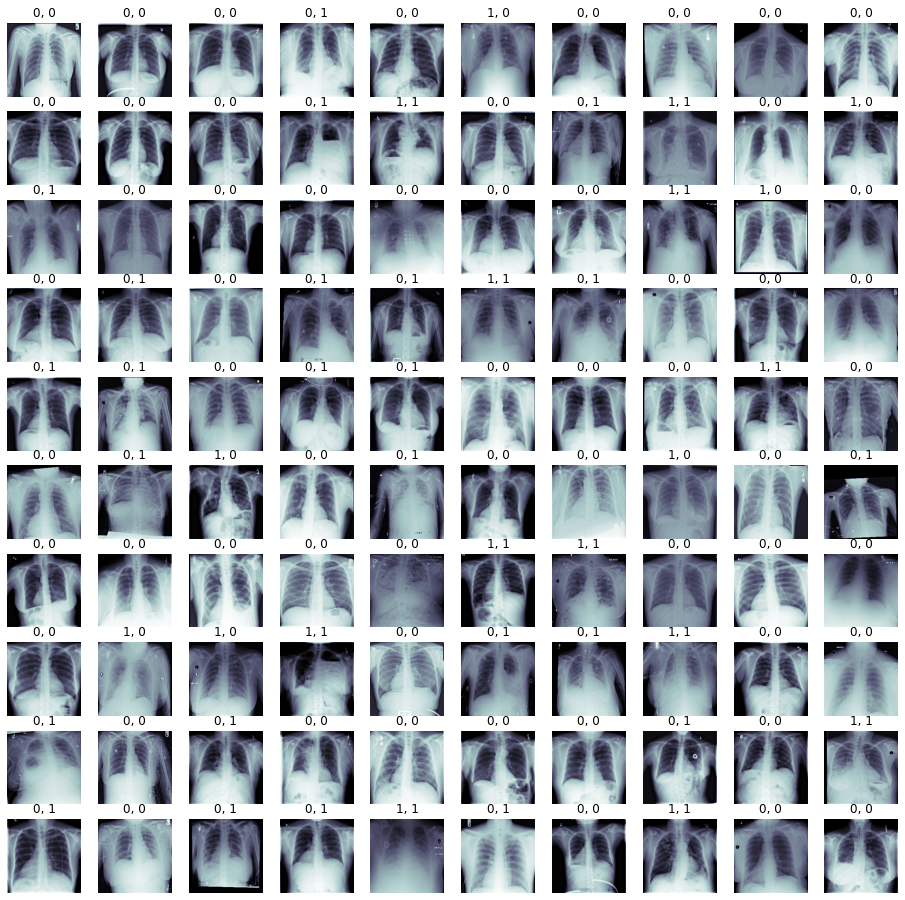

In [79]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [83]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

## Summary - 
* This Model has good recall, but very low precision, which will lead to high number of false positives
* Therefore, it should be used only as an assitance to a radiologist, putting to low priority queue those xrays that were classified as negative by the model.